- synchronize the dimention of the nodes embeddings (dim =4, each) with the input of the server model.(also for ML input dimentions within the server)
- handle the final round to save automaticlly the encoders/weights.
- handle the transfert of encoders/weights and preprocessors automaticlly to the server result folder.
- match model architecture between trainning and load for prediction.
- within the mlr and mlc, match manually the linearVFLmodel class dimentions. (dimentions used during trainning).

we need to get the entire dataset, and extract the relative vital_signs and lab_results,then align them.(all need to be aligned due to VFL logic) And distibute them across nodes.

In [1]:
import functions

In [2]:
csv_paths = ['../data/node3_chartevents/data.csv','../data/node4_labevents/data.csv','../data/node1_patients/data.csv']
original_dataframe = functions.merge_csvs_on_feature(csv_paths=csv_paths,merge_on='subject_id')

In [3]:
_ = functions.analyze_dataframe(original_dataframe)


## DATAFRAME OVERVIEW
----------------------------------------


,Metric,Value
0,Rows,3061
1,Columns,18
2,Total Elements,55098
3,Memory Usage (MB),1.04



## COLUMN INFORMATION
----------------------------------------


,Column,Type,Unique Values,Unique %,Missing Count,Missing %
0,subject_id,int64,3061,100.0%,0,0.00%
1,hadm_id,int64,3061,100.0%,0,0.00%
2,charttime,object,3061,100.0%,0,0.00%
3,heart_rate,float64,119,3.9%,540,17.64%
4,blood_pressure_systolic,float64,104,3.4%,2447,79.94%
5,blood_pressure_diastolic,float64,68,2.2%,2577,84.19%
6,respiratory_rate,float64,45,1.5%,1214,39.66%
7,spo2,float64,21,0.7%,1495,48.84%
8,gender,object,2,0.1%,0,0.00%
9,anchor_age,int64,73,2.4%,0,0.00%



## SAMPLE DATA (First 5 rows)
----------------------------------------


,subject_id,hadm_id,charttime,heart_rate,blood_pressure_systolic,blood_pressure_diastolic,respiratory_rate,spo2,gender,anchor_age,blood_glucose,hemoglobin,wbc,platelet_count,creatinine,anchor_year,anchor_year_group,dod
0,10000032,29079034,2180-07-23 14:12:00,91.0,NaN,NaN,24.0,NaN,F,52,99.0,12.7,37.6,71.0,0.3,2180,2014 - 2016,2180-09-09
1,10000690,25860671,2150-11-02 19:54:00,79.0,NaN,NaN,23.0,100.0,F,86,144.0,10.3,31.9,306.0,85.0,2150,2008 - 2010,2152-01-30
2,10000980,26913865,2189-06-27 08:54:00,NaN,NaN,NaN,23.0,NaN,F,73,NaN,NaN,NaN,NaN,198.0,2186,2008 - 2010,2193-08-26
3,10001217,24597018,2157-11-20 19:19:00,86.0,NaN,NaN,18.0,99.0,F,55,NaN,NaN,NaN,NaN,0.7,2157,2011 - 2013,NaN
4,10001725,25563031,2110-04-11 15:54:00,55.0,NaN,NaN,NaN,NaN,F,46,146.0,13.9,39.1,330.0,0.8,2110,2011 - 2013,NaN



## MISSINGNESS SUMMARY
----------------------------------------
Features with missing values: 11 out of 18
Features with missing values: heart_rate, blood_pressure_systolic, blood_pressure_diastolic, respiratory_rate, spo2, blood_glucose, hemoglobin, wbc, platelet_count, creatinine, dod

Top features with highest missingness:


,Column,Missing Count,Missing %
5,blood_pressure_diastolic,2577,84.19%
4,blood_pressure_systolic,2447,79.94%
17,dod,2043,66.74%
7,spo2,1495,48.84%
6,respiratory_rate,1214,39.66%
3,heart_rate,540,17.64%
10,blood_glucose,535,17.48%
11,hemoglobin,440,14.37%
13,platelet_count,402,13.13%
12,wbc,334,10.91%


The next step is to test correlation (linear and !linear) between features to apply the specific algorithm to the specific features, but the problem is that features are distributed across nodes within the VFL environment, so to test correlation we need to creat an other system that can handle this step with privacy preserving.(tip used : we gonna based on the HFL correlations tests.)

In [4]:
target_column = 'respiratory_rate'
features = ['respiratory_rate','anchor_year','heart_rate']
cleaned_dataframe = functions.prepare_clean_dataset(original_dataframe,features=features)

Original dataset: 3061 rows
Clean dataset: 1702 rows (55.60% of original)

Missing values summary:
Rows missing either feature: 1359


In [5]:
_= functions.analyze_dataframe(cleaned_dataframe)


## DATAFRAME OVERVIEW
----------------------------------------


,Metric,Value
0,Rows,1702
1,Columns,18
2,Total Elements,30636
3,Memory Usage (MB),0.59



## COLUMN INFORMATION
----------------------------------------


,Column,Type,Unique Values,Unique %,Missing Count,Missing %
0,subject_id,int64,1702,100.0%,0,0.00%
1,hadm_id,int64,1702,100.0%,0,0.00%
2,charttime,object,1702,100.0%,0,0.00%
3,heart_rate,float64,115,6.8%,0,0.00%
4,blood_pressure_systolic,float64,93,5.5%,1360,79.91%
5,blood_pressure_diastolic,float64,65,3.8%,1364,80.14%
6,respiratory_rate,float64,44,2.6%,0,0.00%
7,spo2,float64,19,1.1%,651,38.25%
8,gender,object,2,0.1%,0,0.00%
9,anchor_age,int64,73,4.3%,0,0.00%



## SAMPLE DATA (First 5 rows)
----------------------------------------


,subject_id,hadm_id,charttime,heart_rate,blood_pressure_systolic,blood_pressure_diastolic,respiratory_rate,spo2,gender,anchor_age,blood_glucose,hemoglobin,wbc,platelet_count,creatinine,anchor_year,anchor_year_group,dod
0,10000032,29079034,2180-07-23 14:12:00,91.0,NaN,NaN,24.0,NaN,F,52,99.0,12.7,37.6,71.0,0.3,2180,2014 - 2016,2180-09-09
1,10000690,25860671,2150-11-02 19:54:00,79.0,NaN,NaN,23.0,100.0,F,86,144.0,10.3,31.9,306.0,85.0,2150,2008 - 2010,2152-01-30
3,10001217,24597018,2157-11-20 19:19:00,86.0,NaN,NaN,18.0,99.0,F,55,NaN,NaN,NaN,NaN,0.7,2157,2011 - 2013,NaN
9,10002155,23822395,2129-08-04 13:45:00,68.0,90.0,NaN,18.0,NaN,F,80,NaN,NaN,NaN,NaN,73.0,2128,2008 - 2010,2131-03-10
13,10002443,21329021,2183-10-18 00:42:00,106.0,NaN,NaN,12.0,NaN,M,53,226.0,14.4,43.4,307.0,0.8,2183,2017 - 2019,NaN



## MISSINGNESS SUMMARY
----------------------------------------
Features with missing values: 9 out of 18
Features with missing values: blood_pressure_systolic, blood_pressure_diastolic, spo2, blood_glucose, hemoglobin, wbc, platelet_count, creatinine, dod

Top features with highest missingness:


,Column,Missing Count,Missing %
5,blood_pressure_diastolic,1364,80.14%
4,blood_pressure_systolic,1360,79.91%
17,dod,1143,67.16%
7,spo2,651,38.25%
10,blood_glucose,287,16.86%
11,hemoglobin,243,14.28%
13,platelet_count,220,12.93%
12,wbc,190,11.16%
14,creatinine,173,10.16%
16,anchor_year_group,0,0.00%


In [6]:
missing_rate = 0.2
pattern = 'MAR'

data_with_missingness , original_values = functions.introduce_missingness(df=cleaned_dataframe,feature1=features[0],feature2=features[1],missing_rate=missing_rate,task="regression",pattern=pattern)
original_values

Task: regression (using subject_id as index)
Missingness pattern: MAR
Original missing rate: 0.00%
Added 340 missing values
Final missing rate: 19.98%


,original_values,subject_id
0,24.0,10000032
1,23.0,10000690
3,18.0,10001217
9,18.0,10002155
13,12.0,10002443
...,...,...
3055,11.0,10470097
3057,12.0,10470189
3058,14.0,10470531
3059,19.0,10470555


In [7]:
_= functions.analyze_dataframe(data_with_missingness)


## DATAFRAME OVERVIEW
----------------------------------------


,Metric,Value
0,Rows,1702
1,Columns,18
2,Total Elements,30636
3,Memory Usage (MB),0.66



## COLUMN INFORMATION
----------------------------------------


,Column,Type,Unique Values,Unique %,Missing Count,Missing %
0,subject_id,int64,1702,100.0%,0,0.00%
1,hadm_id,int64,1702,100.0%,0,0.00%
2,charttime,object,1702,100.0%,0,0.00%
3,heart_rate,float64,115,6.8%,0,0.00%
4,blood_pressure_systolic,float64,93,5.5%,1360,79.91%
5,blood_pressure_diastolic,float64,65,3.8%,1364,80.14%
6,respiratory_rate,float64,42,2.5%,340,19.98%
7,spo2,float64,19,1.1%,651,38.25%
8,gender,object,2,0.1%,0,0.00%
9,anchor_age,int64,73,4.3%,0,0.00%



## SAMPLE DATA (First 5 rows)
----------------------------------------


,subject_id,hadm_id,charttime,heart_rate,blood_pressure_systolic,blood_pressure_diastolic,respiratory_rate,spo2,gender,anchor_age,blood_glucose,hemoglobin,wbc,platelet_count,creatinine,anchor_year,anchor_year_group,dod
0,10000032,29079034,2180-07-23 14:12:00,91.0,NaN,NaN,24.0,NaN,F,52,99.0,12.7,37.6,71.0,0.3,2180,2014 - 2016,2180-09-09
1,10000690,25860671,2150-11-02 19:54:00,79.0,NaN,NaN,23.0,100.0,F,86,144.0,10.3,31.9,306.0,85.0,2150,2008 - 2010,2152-01-30
3,10001217,24597018,2157-11-20 19:19:00,86.0,NaN,NaN,18.0,99.0,F,55,NaN,NaN,NaN,NaN,0.7,2157,2011 - 2013,NaN
9,10002155,23822395,2129-08-04 13:45:00,68.0,90.0,NaN,18.0,NaN,F,80,NaN,NaN,NaN,NaN,73.0,2128,2008 - 2010,2131-03-10
13,10002443,21329021,2183-10-18 00:42:00,106.0,NaN,NaN,12.0,NaN,M,53,226.0,14.4,43.4,307.0,0.8,2183,2017 - 2019,NaN



## MISSINGNESS SUMMARY
----------------------------------------
Features with missing values: 10 out of 18
Features with missing values: blood_pressure_systolic, blood_pressure_diastolic, respiratory_rate, spo2, blood_glucose, hemoglobin, wbc, platelet_count, creatinine, dod

Top features with highest missingness:


,Column,Missing Count,Missing %
5,blood_pressure_diastolic,1364,80.14%
4,blood_pressure_systolic,1360,79.91%
17,dod,1143,67.16%
7,spo2,651,38.25%
6,respiratory_rate,340,19.98%
10,blood_glucose,287,16.86%
11,hemoglobin,243,14.28%
13,platelet_count,220,12.93%
12,wbc,190,11.16%
14,creatinine,173,10.16%


In [8]:
dataframe_with_predictions =functions.return_regression_results(data_with_missingness,target=target_column)
data_with_missingness

Loaded model info from ../server/results/dl_regression\model_info.json
Loaded model state_dict from ../server/results/dl_regression\final_model_state_dict.pth
Loading client encoders from ../server/results/dl_regression\encoders
Loaded encoder for node 1
Loaded encoder for node 3
Loading node preprocessors from ../server/results/dl_regression\nodes_preprocessor
Loaded preprocessor for node 1
Loaded preprocessor for node 3
Loading server preprocessor from ../server/results/dl_regression\server_preprocessor
Loaded target scaler
--------------- Retrieved features are {'1': ['anchor_year'], '3': ['heart_rate']}
Used node-specific preprocessor for node 1
Used node-specific preprocessor for node 3
Applied inverse scaling using num transformer


C:\Users\BeeClick\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\BeeClick\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.4.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(

,subject_id,hadm_id,charttime,heart_rate,blood_pressure_systolic,blood_pressure_diastolic,respiratory_rate,spo2,gender,anchor_age,blood_glucose,hemoglobin,wbc,platelet_count,creatinine,anchor_year,anchor_year_group,dod
0,10000032,29079034,2180-07-23 14:12:00,91.0,NaN,NaN,24.0,NaN,F,52,99.0,12.7,37.6,71.0,0.3,2180,2014 - 2016,2180-09-09
1,10000690,25860671,2150-11-02 19:54:00,79.0,NaN,NaN,23.0,100.0,F,86,144.0,10.3,31.9,306.0,85.0,2150,2008 - 2010,2152-01-30
3,10001217,24597018,2157-11-20 19:19:00,86.0,NaN,NaN,18.0,99.0,F,55,NaN,NaN,NaN,NaN,0.7,2157,2011 - 2013,NaN
9,10002155,23822395,2129-08-04 13:45:00,68.0,90.0,NaN,18.0,NaN,F,80,NaN,NaN,NaN,NaN,73.0,2128,2008 - 2010,2131-03-10
13,10002443,21329021,2183-10-18 00:42:00,106.0,NaN,NaN,12.0,NaN,M,53,226.0,14.4,43.4,307.0,0.8,2183,2017 - 2019,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,10470097,26270553,2197-01-10 08:00:00,70.0,NaN,NaN,11.0,94.0,M,27,822.0,15.3,45.1,316.0,1.2,2194,2008 - 2010,NaN
3057,10470189,23918063,2162-01-08 06:00:00,77.0,NaN,NaN,12.0,NaN,F,58,NaN,NaN,NaN,NaN,0.5,2162,2011 - 2013,NaN
3058,10470531,23351416,2118-10-03 03:49:00,72.0,NaN,NaN,NaN,100.0,F,38,205.0,13.1,39.7,261.0,0.7,2118,2020 - 2022,NaN
3059,10470555,25629836,2113-12-28 01:40:00,67.0,NaN,NaN,NaN,92.0,F,71,92.0,14.4,44.0,276.0,0.6,2113,2017 - 2019,2114-06-28



ANALYSIS OF FEATURE: respiratory_rate_dl

--- Basic Information ---
Data type: float32
Missing values: 0 (0.00%)
Unique values: 736 (43.24% of total)

--- Numeric Analysis ---
       Statistic        Value
0          count  1702.000000
1           mean    20.021610
2            std     0.057076
3            min    19.517267
4            25%    19.996698
5   50% (median)    20.051115
6            75%    20.055882
7            max    20.075726
8       skewness    -1.710995
9       kurtosis     3.865438
10           IQR     0.059184
11         range     0.558458

Outliers (IQR method): 135 (7.93% of non-null values)
Outlier bounds: Lower < 19.91 or Upper > 20.14

Shapiro-Wilk Normality Test: statistic=0.7146, p-value=0.0000
Feature does not appear normally distributed (p < 0.05)


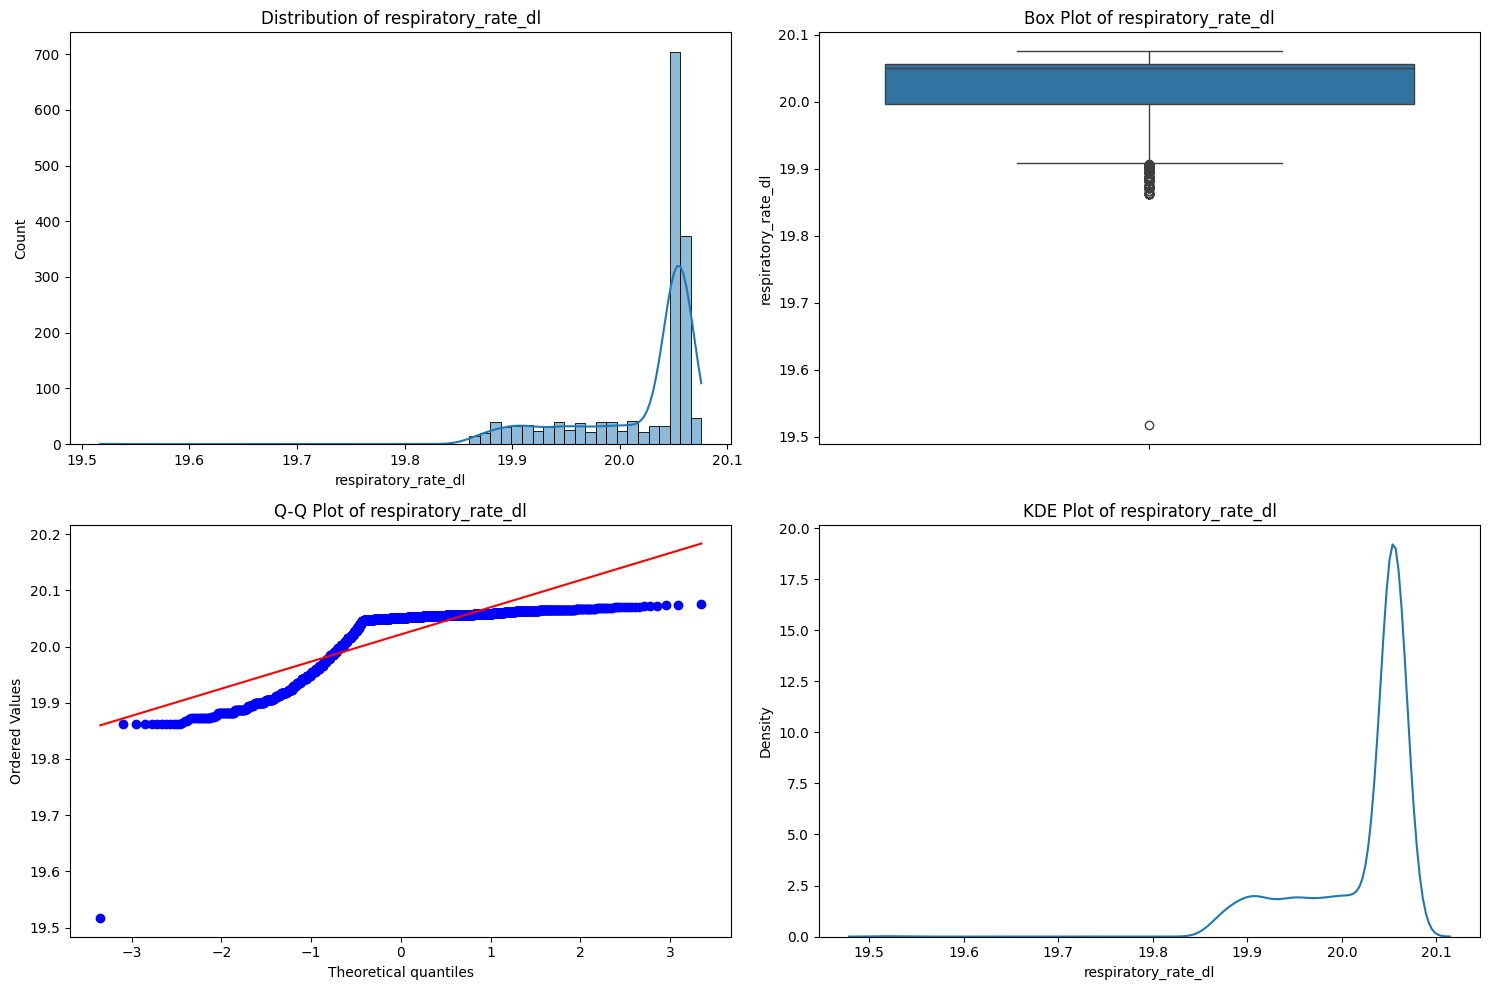


--- Correlation with Other Numeric Features ---
                     Feature  Pearson Correlation
0        respiratory_rate_ml             0.798200
1                anchor_year             0.783279
2                 anchor_age             0.040378
3                 subject_id             0.022054
4                 creatinine             0.020738
5                    hadm_id             0.007206
6           respiratory_rate            -0.002596
7              blood_glucose            -0.011062
8                       spo2            -0.014765
9                 hemoglobin            -0.018469
10            platelet_count            -0.020356
11                       wbc            -0.033742
12  blood_pressure_diastolic            -0.045624
13   blood_pressure_systolic            -0.075504
14                heart_rate            -0.206807


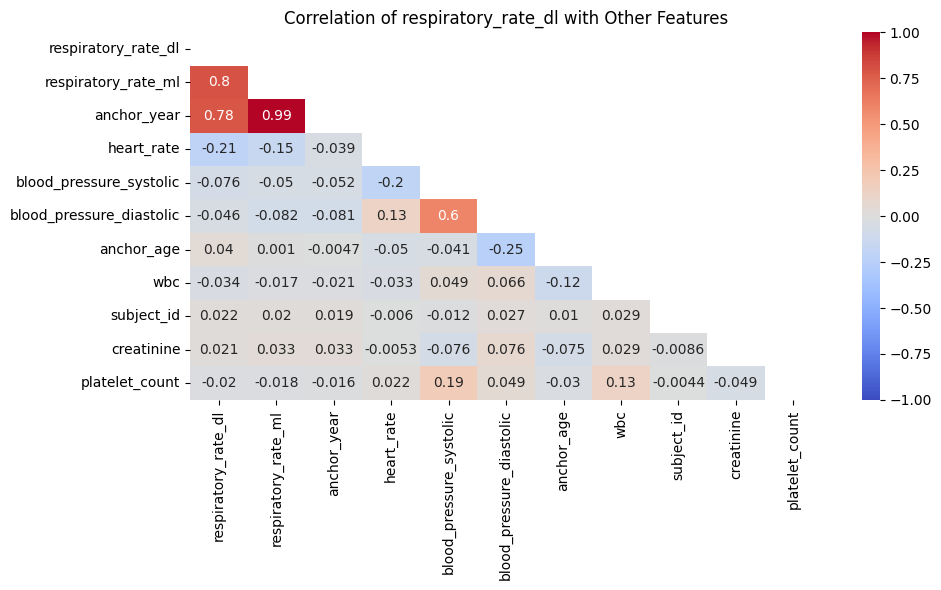

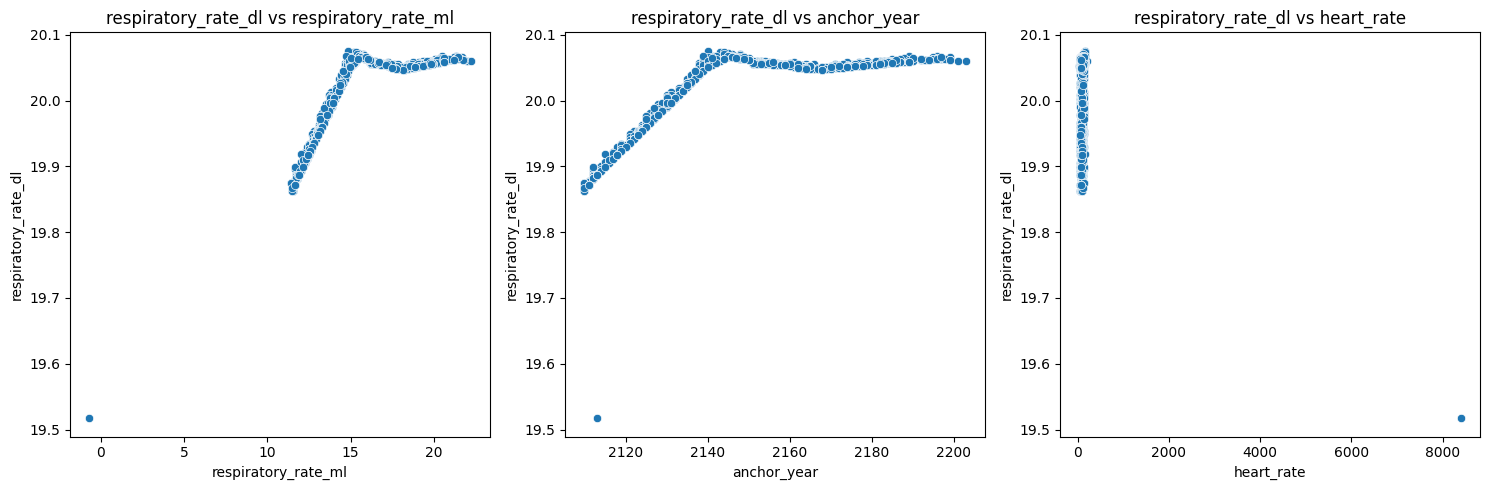

In [9]:
functions.analyze_feature(dataframe_with_predictions,target_column+'_dl') # ml or dl regression approches

BENCHMARKING PREDICTIONS FOR RESPIRATORY_RATE

Found 2 prediction approaches:
  - respiratory_rate_ml
  - respiratory_rate_dl

Analyzing 1702 rows with matching subject_id values.

--------------------------------------------------------------------------------
GLOBAL PERFORMANCE METRICS
--------------------------------------------------------------------------------
  Approach   RMSE    MAE MAPE (%)      R²  Explained Variance  Mean Error  \
1       dl 6.1089 4.7885    28.64 -0.0295             -0.0005     -1.0251   
0       ml 7.2731 5.3555    27.09 -0.4593             -0.2393      2.8243   

   Error Std  Correlation  
1     6.0222      -0.0234  
0     6.7023      -0.0451  

Best performing approach: dl (RMSE: 6.1089)

--------------------------------------------------------------------------------
VISUALIZING PREDICTIONS VS ACTUAL VALUES
--------------------------------------------------------------------------------


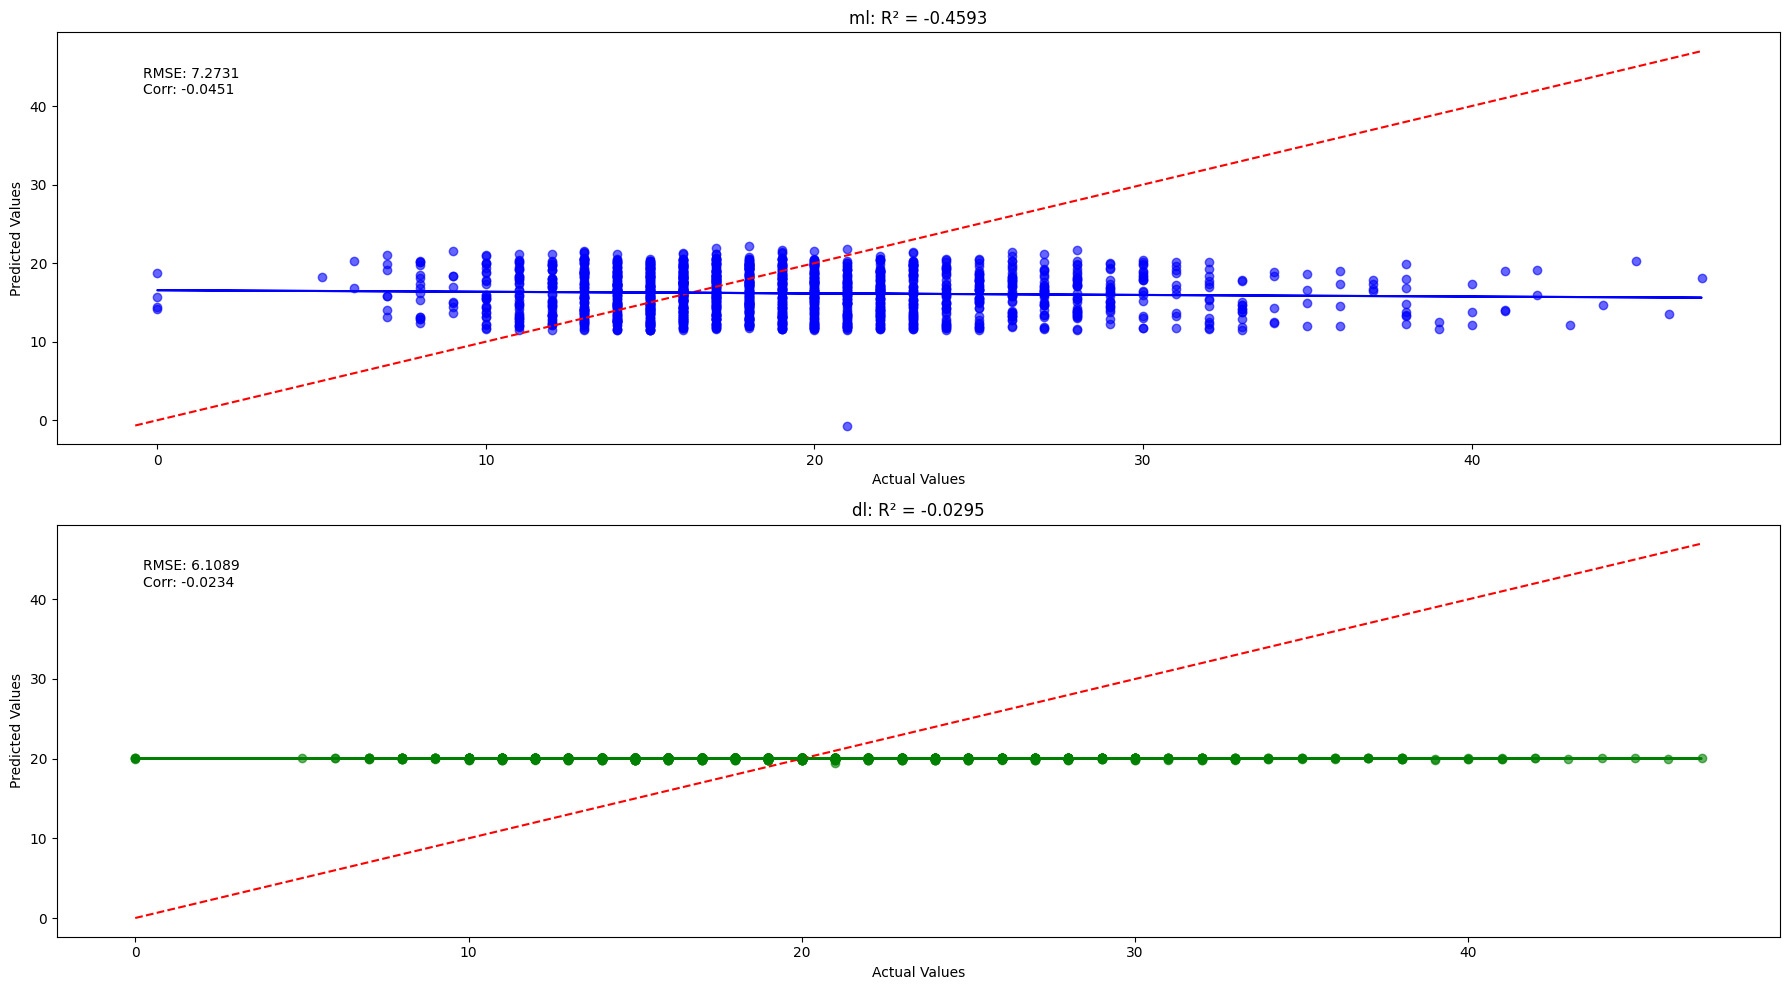

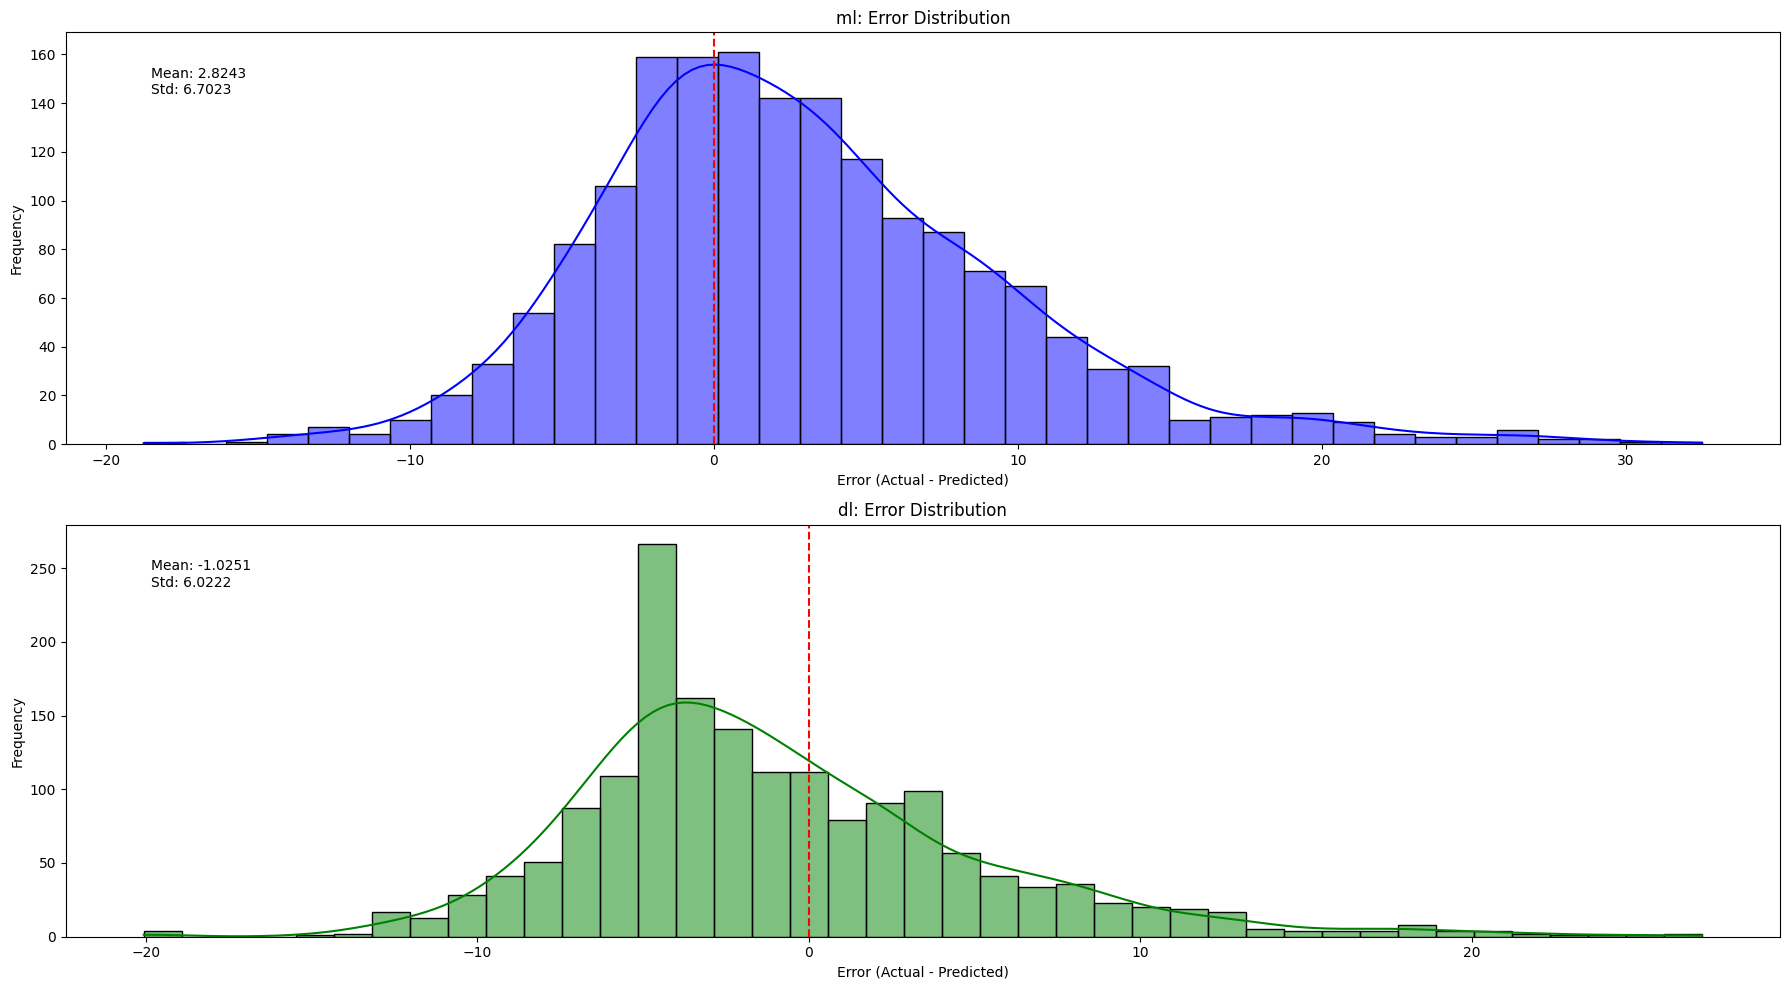

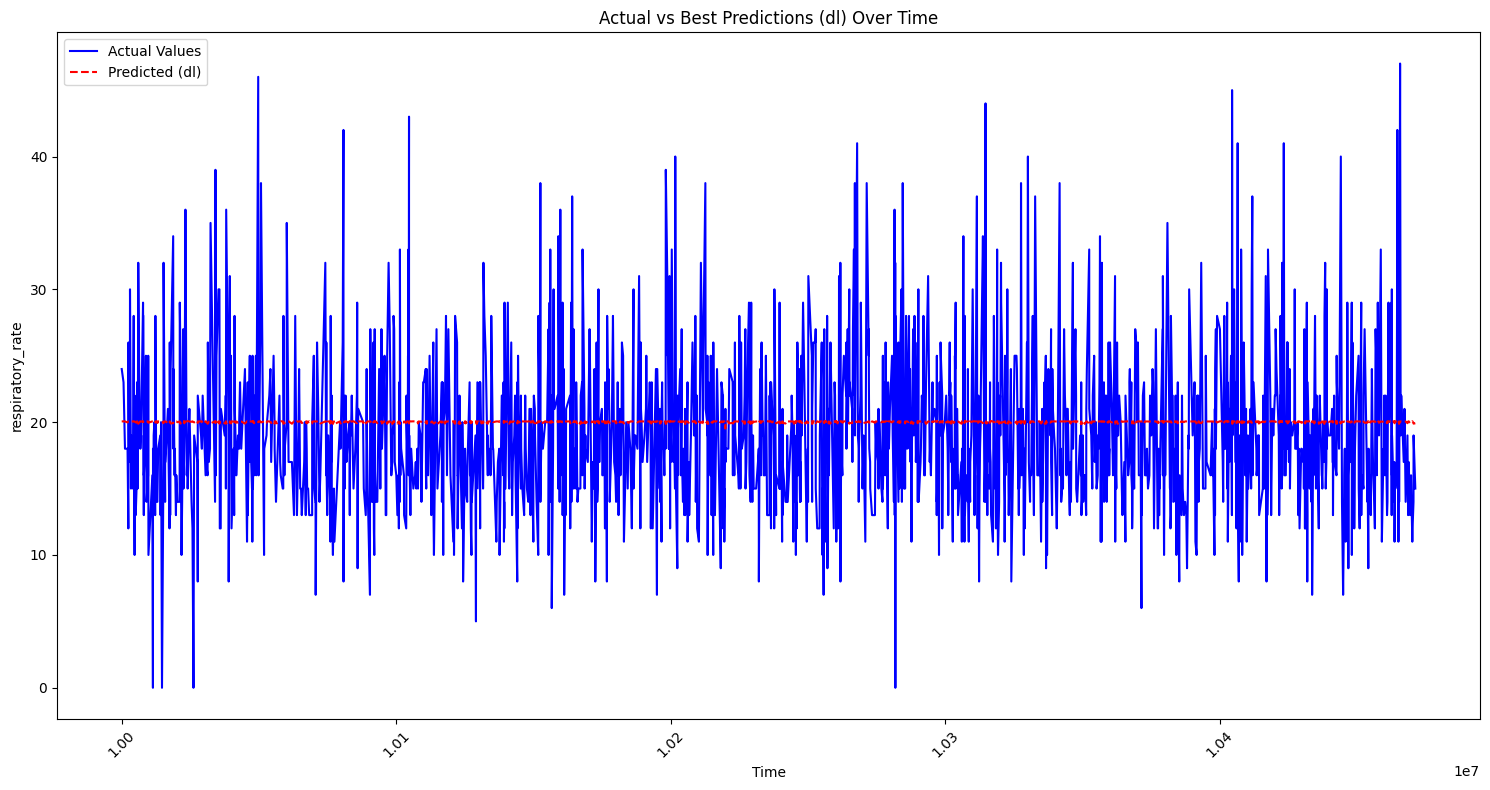

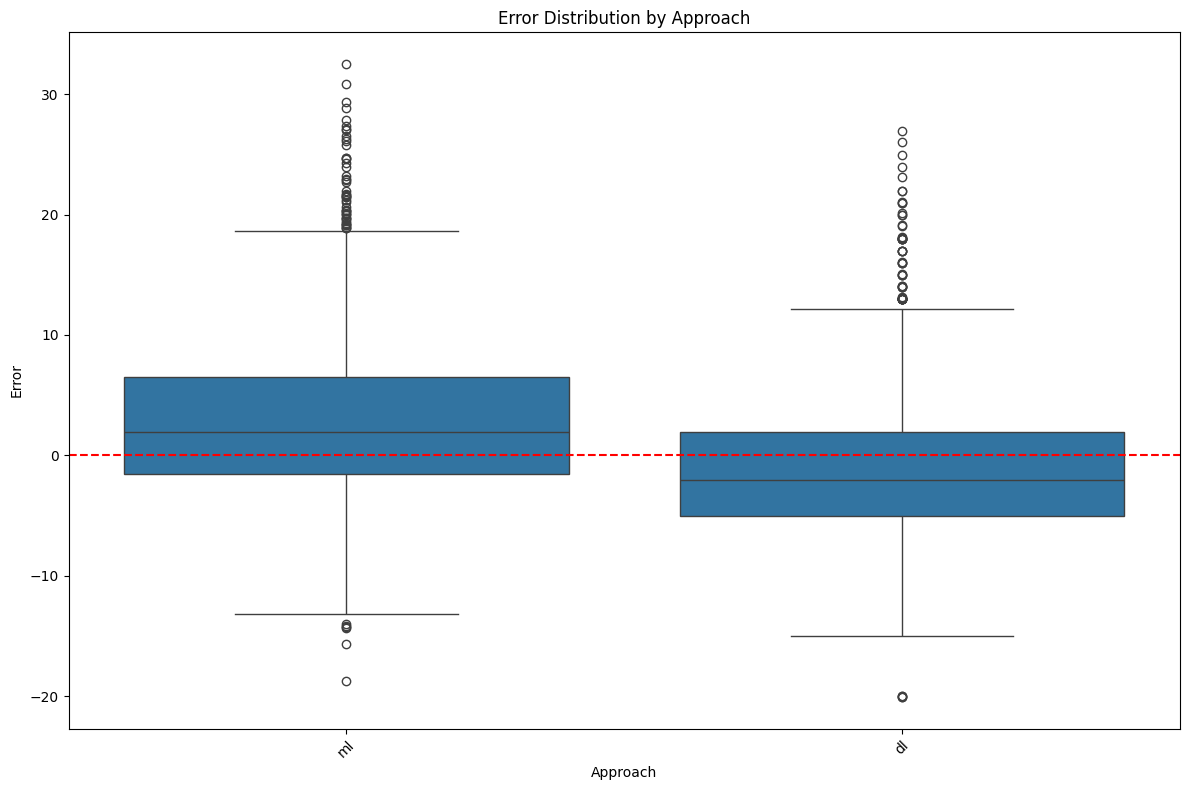

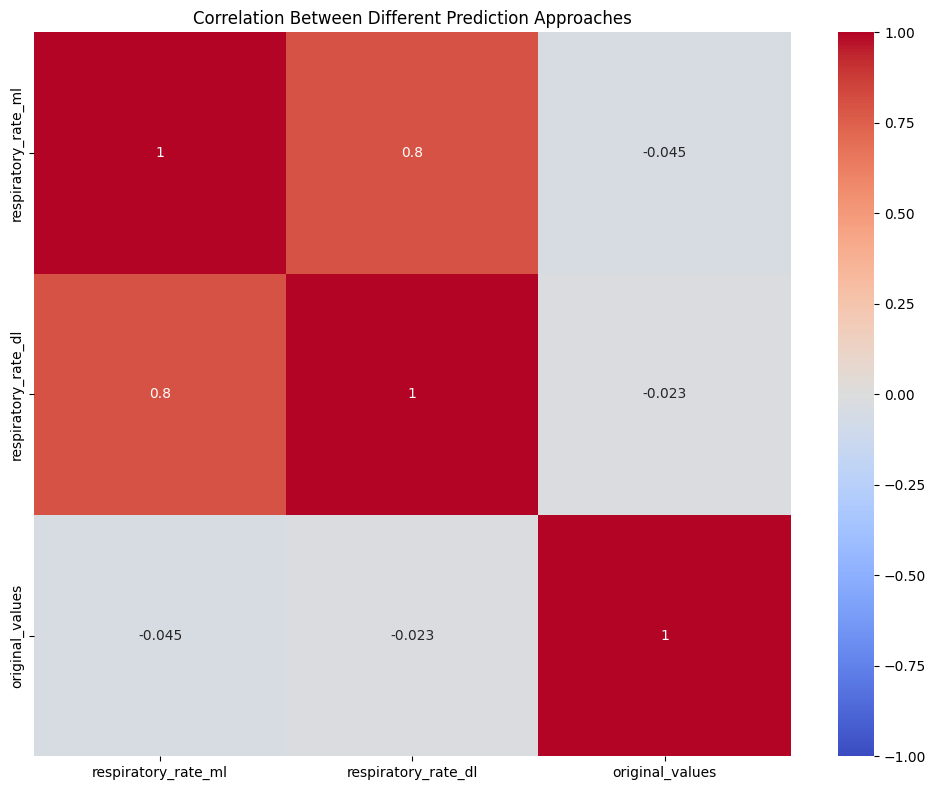


--------------------------------------------------------------------------------
DETAILED ERROR ANALYSIS
--------------------------------------------------------------------------------
Percentage of predictions within error ranges:
      < 5%   5-10%  10-20%   > 20%
ml 11.5159 11.9271 21.0928 55.4642
dl 11.2808 11.8684 24.3831 52.4677

--------------------------------------------------------------------------------
SUMMARY OF FINDINGS
--------------------------------------------------------------------------------
1. Best performing approach: dl
2. Ranking of approaches by RMSE (best to worst):
   1. dl (RMSE: 6.1089)
   2. ml (RMSE: 7.2731)
3. The best approach (dl) has:
   - 11.3% of predictions within 5% of actual values
   - 23.1% of predictions within 10% of actual values


In [10]:
_ =functions.benchmark_predictions(dataframe_with_predictions,original_values,target=target_column,task_type='regression')